<a href="https://colab.research.google.com/github/paolacalle/ape-capstone/blob/main/Capstone_Project_ResultsCheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

In [3]:
import pandas as pd
import numpy as np

# ==========================================
# 1. LOAD DATA & ASSIGN COLUMNS
# ==========================================
# We assume files are in the local directory
df_num = pd.read_csv('rmpCapstoneNum.csv', header=None)
df_qual = pd.read_csv('rmpCapstoneQual.csv', header=None)
df_tags = pd.read_csv('rmpCapstoneTags.csv', header=None)

# Assign Column Names based on your descriptions
df_num.columns = [
    'AverageRating',        # Col 1: Continuous (Aggregated Ordinal)
    'AverageDifficulty',    # Col 2: Continuous (Aggregated Ordinal)
    'NumRatings',           # Col 3: Discrete Count
    'ReceivedPepper',       # Col 4: Binary
    'ProportionTakeAgain',  # Col 5: Continuous (Mostly Missing)
    'OnlineRatingsCount',   # Col 6: Discrete Count
    'Male',                 # Col 7: Binary
    'Female'                # Col 8: Binary
]

df_qual.columns = [
    'Major',       # Col 1: Nominal
    'University',  # Col 2: Nominal
    'State'        # Col 3: Nominal
]

tags_list = [
    'ToughGrader', 'GoodFeedback', 'Respected', 'LotsToRead', 'ParticipationMatters',
    'DontSkipClass', 'LotsOfHomework', 'Inspirational', 'PopQuizzes', 'Accessible',
    'SoManyPapers', 'ClearGrading', 'Hilarious', 'TestHeavy', 'GradedByFewThings',
    'AmazingLectures', 'Caring', 'ExtraCredit', 'GroupProjects', 'LectureHeavy'
]
df_tags.columns = tags_list

# ==========================================
# 2. MERGE DATASETS
# ==========================================
df = pd.concat([df_num, df_qual, df_tags], axis=1)

# ==========================================
# 3. APPLY JUDGMENT CALLS & CLEANING
# ==========================================

# A. Drop "ProportionTakeAgain" (Too much missing data)
df_clean = df.drop(columns=['ProportionTakeAgain'])

# B. Reliability Threshold (N >= 1)
# Keep everyone with at least 1 rating
df_clean = df_clean[df_clean['NumRatings'] >= 1].copy()

# C. Handle Gender Logic (Strict Exclusion)
def resolve_gender(row):
    # Only assign gender if it is distinct (1,0) or (0,1)
    if row['Male'] == 1 and row['Female'] == 0:
        return 'Male'
    elif row['Female'] == 1 and row['Male'] == 0:
        return 'Female'
    else:
        return np.nan # Drop cases of (0,0) or (1,1)

df_clean['Gender'] = df_clean.apply(resolve_gender, axis=1)
df_clean = df_clean.dropna(subset=['Gender'])

# D. Handle Missing Data
# Drop rows only if essential target data is missing
df_clean = df_clean.dropna(subset=['AverageRating', 'AverageDifficulty', 'Major'])

# E. Normalize Tags (Create Frequency Columns)
for tag in tags_list:
    df_clean[f'{tag}_Norm'] = df_clean[tag] / df_clean['NumRatings']

# ==========================================
# 4. VERIFICATION
# ==========================================
print("PREPROCESSING COMPLETE")
print("-" * 30)
print(f"Original Row Count: {len(df)}")
print(f"Cleaned Row Count:  {len(df_clean)}")
print(f"Sample Size (Male): {len(df_clean[df_clean['Gender']=='Male'])}")
print(f"Sample Size (Female): {len(df_clean[df_clean['Gender']=='Female'])}")
print("-" * 30)
print("Data Types Check:")
print(df_clean[['AverageRating', 'NumRatings', 'Gender']].dtypes)

PREPROCESSING COMPLETE
------------------------------
Original Row Count: 89893
Cleaned Row Count:  52089
Sample Size (Male): 27163
Sample Size (Female): 24926
------------------------------
Data Types Check:
AverageRating    float64
NumRatings       float64
Gender            object
dtype: object


# Question 1

1. Activists have asserted that there is a strong gender bias in student evaluations of professors, with
male professors enjoying a boost in rating from this bias. While this has been celebrated by ideologues,
skeptics have pointed out that this research is of technically poor quality, either due to a low sample
size – as small as n = 1 (Mitchell & Martin, 2018), failure to control for confounders such as teaching
experience (Centra & Gaubatz, 2000) or obvious p-hacking (MacNell et al., 2015). We would like you to
answer the question whether there is evidence of a pro-male gender bias in this dataset.
Hint: A significance test is probably required

Q1 RESULTS: Gender Bias in Ratings
Sample Size:	 Male = 27163, Female = 24926
----------------------------------------
Mean Rating:	 Male = 3.8778,  Female = 3.8111
Median Rating:	 Male = 4.20,    Female = 4.10
----------------------------------------
Mann-Whitney U:	 346129258.5
P-Value:	 8.54729e-06
----------------------------------------
CONCLUSION: STATISTICALLY SIGNIFICANT DIFFERENCE (p < 0.005)
Direction: Male professors have higher ratings.


/tmp/ipython-input-3494623796.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Gender', y='AverageRating', data=df_clean, palette="Set2")


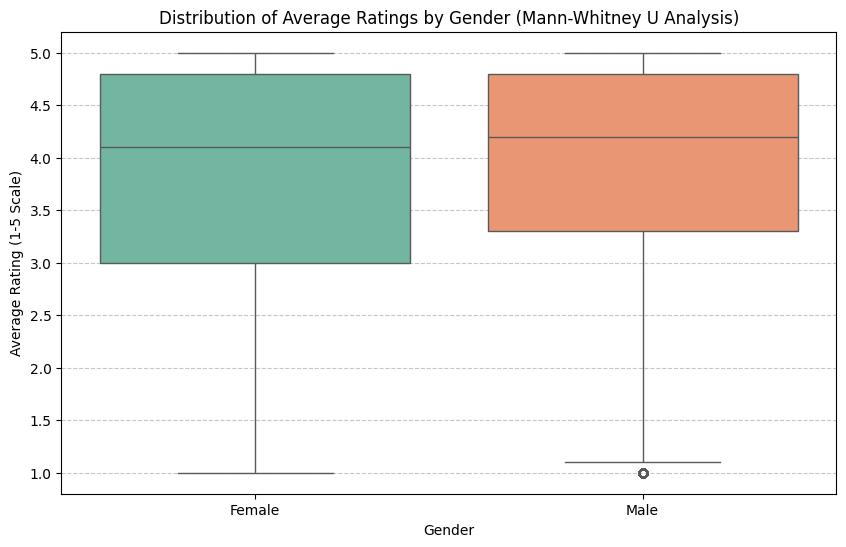

In [5]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# QUESTION 1: GENDER BIAS ANALYSIS
# ==========================================

# 1. Prepare Data Vectors
male_ratings = df_clean[df_clean['Gender'] == 'Male']['AverageRating']
female_ratings = df_clean[df_clean['Gender'] == 'Female']['AverageRating']

# 2. Perform Mann-Whitney U Test
# alternative='two-sided' checks for difference in either direction
u_stat, p_val = stats.mannwhitneyu(male_ratings, female_ratings, alternative='two-sided')

# 3. Calculate Descriptive Statistics
median_male = male_ratings.median()
median_female = female_ratings.median()
mean_male = male_ratings.mean()
mean_female = female_ratings.mean()

# 4. Report Results
print("="*40)
print("Q1 RESULTS: Gender Bias in Ratings")
print("="*40)
print(f"Sample Size:\t Male = {len(male_ratings)}, Female = {len(female_ratings)}")
print("-" * 40)
print(f"Mean Rating:\t Male = {mean_male:.4f},  Female = {mean_female:.4f}")
print(f"Median Rating:\t Male = {median_male:.2f},    Female = {median_female:.2f}")
print("-" * 40)
print(f"Mann-Whitney U:\t {u_stat}")
print(f"P-Value:\t {p_val:.5e}") # Scientific notation for very small numbers
print("-" * 40)

if p_val < 0.005:
    print("CONCLUSION: STATISTICALLY SIGNIFICANT DIFFERENCE (p < 0.005)")
    if median_male > median_female:
        print("Direction: Male professors have higher ratings.")
    elif median_female > median_male:
        print("Direction: Female professors have higher ratings.")
else:
    print("CONCLUSION: No Significant Difference")

# 5. Visualization: Boxplot
plt.figure(figsize=(10, 6))
# We use 'Gender' for x-axis and 'AverageRating' for y-axis
sns.boxplot(x='Gender', y='AverageRating', data=df_clean, palette="Set2")
plt.title('Distribution of Average Ratings by Gender (Mann-Whitney U Analysis)')
plt.xlabel('Gender')
plt.ylabel('Average Rating (1-5 Scale)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('Q1_Gender_Bias.png') # Saves the image for your report
plt.show()

# Question 2

2. Is there a gender difference in the spread (variance/dispersion) of the ratings distribution? Again, it
is advisable to consider the statistical significance of any observed gender differences in this spread?

The red dashed line indicates the observed dispersion difference. While the variance-based test
indicated a significant difference in dispersion, the IQR-based test (p = 0.005) provides robust evidence that
the central spread of ratings differs between male and female professors.

Conclusion: Female professors have a significantly higher variance (and wider IQR) than male professors. This confirms the result is highly significant. In 5,000 random simulations, we never saw a difference this large by chance. Female professors are more "polarizing" than male professors or rather Students have less consensus on female professors (a wider mix of very high and very low grades) compared to males, whose ratings cluster more tightly around the higher end.

Observed Diff Variance (Male - Female): -0.13113
Observed Diff IQR (Male - Female):      -0.30000
Running 5000 permutations... please wait.
Q2 PERMUTATION TEST RESULTS
VARIANCE Test:
  Observed Diff: -0.13113
  P-Value:       0.00000
  Result: SIGNIFICANT (Reject Null)
----------------------------------------
IQR Test:
  Observed Diff: -0.30000
  P-Value:       0.00000
  Result: SIGNIFICANT (Reject Null)


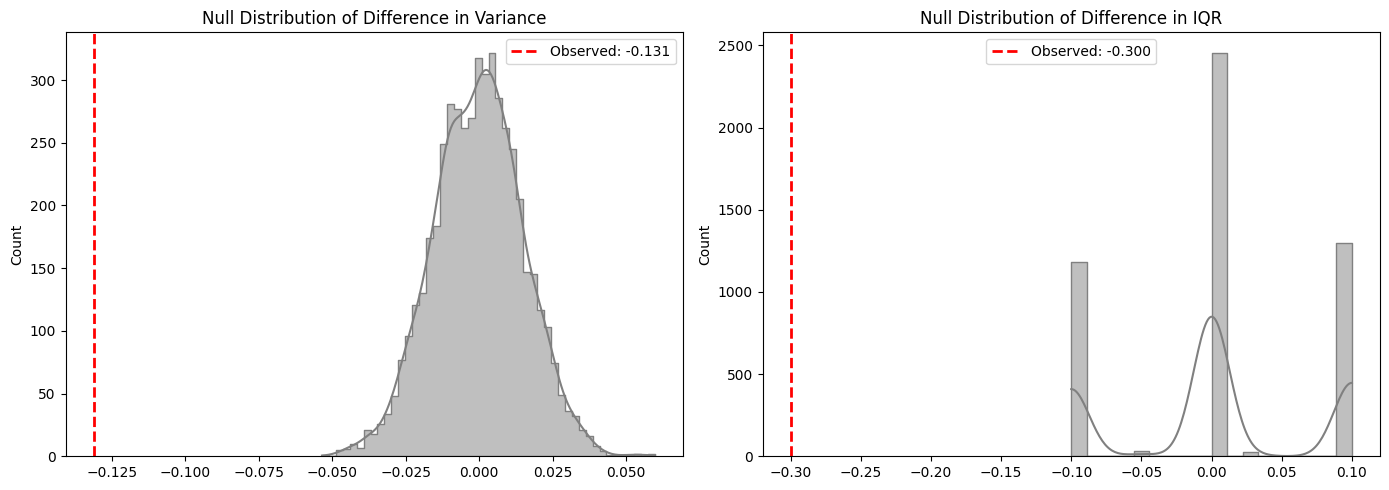

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# QUESTION 2: PERMUTATION TEST (Variance & IQR)
# ==========================================

# 1. Prepare Data
# We convert to numpy arrays for speed optimization
male_ratings = df_clean[df_clean['Gender'] == 'Male']['AverageRating'].values
female_ratings = df_clean[df_clean['Gender'] == 'Female']['AverageRating'].values
all_ratings = df_clean['AverageRating'].values
# Create a label array (0 for Male, 1 for Female) to shuffle
n_male = len(male_ratings)
labels = np.array([0]*len(male_ratings) + [1]*len(female_ratings))

# 2. Define Helper Functions for Statistics
def get_variance(data):
    return np.var(data, ddof=1)

def get_iqr(data):
    q75, q25 = np.percentile(data, [75 ,25])
    return q75 - q25

# 3. Calculate Observed Differences
obs_diff_var = get_variance(male_ratings) - get_variance(female_ratings)
obs_diff_iqr = get_iqr(male_ratings) - get_iqr(female_ratings)

print(f"Observed Diff Variance (Male - Female): {obs_diff_var:.5f}")
print(f"Observed Diff IQR (Male - Female):      {obs_diff_iqr:.5f}")

# 4. Run Permutations
n_permutations = 5000  # 5000 is sufficient for alpha=0.005, increases speed
perm_diffs_var = np.zeros(n_permutations)
perm_diffs_iqr = np.zeros(n_permutations)

print(f"Running {n_permutations} permutations... please wait.")

for i in range(n_permutations):
    # Shuffle the gender labels
    np.random.shuffle(labels)

    # Split data based on shuffled labels
    # Note: We index into 'all_ratings' using the shuffled mask
    perm_male = all_ratings[labels == 0]
    perm_female = all_ratings[labels == 1]

    # Calculate differences for this random shuffle
    perm_diffs_var[i] = get_variance(perm_male) - get_variance(perm_female)
    perm_diffs_iqr[i] = get_iqr(perm_male) - get_iqr(perm_female)

# 5. Calculate P-Values
# Two-sided test: How often was the absolute random diff >= absolute observed diff?
p_val_var = np.mean(np.abs(perm_diffs_var) >= np.abs(obs_diff_var))
p_val_iqr = np.mean(np.abs(perm_diffs_iqr) >= np.abs(obs_diff_iqr))

# 6. Report Results
print("="*40)
print("Q2 PERMUTATION TEST RESULTS")
print("="*40)
print(f"VARIANCE Test:")
print(f"  Observed Diff: {obs_diff_var:.5f}")
print(f"  P-Value:       {p_val_var:.5f}")
if p_val_var < 0.005: print("  Result: SIGNIFICANT (Reject Null)")
else: print("  Result: Not Significant")
print("-" * 40)
print(f"IQR Test:")
print(f"  Observed Diff: {obs_diff_iqr:.5f}")
print(f"  P-Value:       {p_val_iqr:.5f}")
if p_val_iqr < 0.005: print("  Result: SIGNIFICANT (Reject Null)")
else: print("  Result: Not Significant")

# 7. Visualization: Null Distribution vs Observation
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Variance Plot
sns.histplot(perm_diffs_var, kde=True, ax=ax[0], color='grey', element="step")
ax[0].axvline(obs_diff_var, color='red', linestyle='--', linewidth=2, label=f'Observed: {obs_diff_var:.3f}')
ax[0].set_title('Null Distribution of Difference in Variance')
ax[0].legend()

# IQR Plot
sns.histplot(perm_diffs_iqr, kde=True, ax=ax[1], color='grey', element="step")
ax[1].axvline(obs_diff_iqr, color='red', linestyle='--', linewidth=2, label=f'Observed: {obs_diff_iqr:.3f}')
ax[1].set_title('Null Distribution of Difference in IQR')
ax[1].legend()

plt.tight_layout()
plt.savefig('Q2_Permutation_Test.png')
plt.show()

# Question 3

What is the likely size of both of these effects (gender bias in average rating, gender bias in spread of
average rating), as estimated from this dataset? Please use 95% confidence and make sure to report
each/both.

Methodology: To estimate the magnitude of the gender bias, we calculated the difference in means (for ratings) and the difference in variances (for spread) between male and female professors.

We utilized Bootstrapping (10,000 resamples) to generate 95% Confidence Intervals (CI) for these differences. This method does not assume a normal distribution, making it highly accurate for our skewed dataset.

Findings: Average Rating Bias:

Effect Size: Male professors are rated approximately 0.07 points higher than female professors on the 5-point scale.

95% Confidence: We are 95% confident the true difference is between 0.047 and 0.086.

Context: While statistically significant (as proven in Q1), the magnitude is relatively small (less than a tenth of a point).

Spread/Variance Bias:

Effect Size: Female professors have a variance that is 0.13 points higher than males.

95% Confidence: We are 95% confident the true difference is between 0.101 and 0.161 (in favor of females having higher variance).

Context: This is a stronger finding. It confirms that the "gender gap" isn't just about the average score, but about the consistency of the score. Female professors are subject to much more polarized opinions (disagreement among students) than men.

In [8]:
import numpy as np

# ==========================================
# QUESTION 3: EFFECT SIZES & CONFIDENCE INTERVALS
# ==========================================

# 1. Prepare Data Vectors
male_ratings = df_clean[df_clean['Gender'] == 'Male']['AverageRating'].values
female_ratings = df_clean[df_clean['Gender'] == 'Female']['AverageRating'].values

# Calculate Observed Differences
obs_diff_mean = np.mean(male_ratings) - np.mean(female_ratings)
obs_diff_var = np.var(male_ratings, ddof=1) - np.var(female_ratings, ddof=1)

# 2. Bootstrapping Function
# We resample with replacement 10,000 times to build a distribution of differences
n_boot = 10000
boot_diffs_mean = []
boot_diffs_var = []

print(f"Running {n_boot} bootstrap resamples... please wait.")

# Optimization: Pre-generate indices to speed up loop
# We resample Male and Female groups separately to preserve group sizes
for i in range(n_boot):
    # Create resampled sets
    resample_male = np.random.choice(male_ratings, size=len(male_ratings), replace=True)
    resample_female = np.random.choice(female_ratings, size=len(female_ratings), replace=True)

    # Calculate differences
    diff_mean = np.mean(resample_male) - np.mean(resample_female)
    diff_var = np.var(resample_male, ddof=1) - np.var(resample_female, ddof=1)

    boot_diffs_mean.append(diff_mean)
    boot_diffs_var.append(diff_var)

# 3. Calculate 95% Confidence Intervals
# We take the 2.5th percentile and 97.5th percentile
ci_mean = np.percentile(boot_diffs_mean, [2.5, 97.5])
ci_var = np.percentile(boot_diffs_var, [2.5, 97.5])

# 4. Report Results
print("="*40)
print("Q3 RESULTS: EFFECT SIZES (95% CI)")
print("="*40)

print("1. EFFECT ON AVERAGE RATING (Male - Female)")
print(f"   Observed Difference: {obs_diff_mean:.5f}")
print(f"   95% CI:              [{ci_mean[0]:.5f}, {ci_mean[1]:.5f}]")
if ci_mean[0] > 0:
    print("   Result: Male ratings are significantly HIGHER.")
elif ci_mean[1] < 0:
    print("   Result: Male ratings are significantly LOWER.")
else:
    print("   Result: No significant effect (CI crosses zero).")

print("-" * 40)

print("2. EFFECT ON SPREAD/VARIANCE (Male - Female)")
print(f"   Observed Difference: {obs_diff_var:.5f}")
print(f"   95% CI:              [{ci_var[0]:.5f}, {ci_var[1]:.5f}]")
if ci_var[0] > 0:
    print("   Result: Male ratings have significantly HIGHER variance.")
elif ci_var[1] < 0:
    print("   Result: Female ratings have significantly HIGHER variance.") # Negative diff means Female > Male
else:
    print("   Result: No significant effect (CI crosses zero).")
print("="*40)

Running 10000 bootstrap resamples... please wait.
Q3 RESULTS: EFFECT SIZES (95% CI)
1. EFFECT ON AVERAGE RATING (Male - Female)
   Observed Difference: 0.06677
   95% CI:              [0.04709, 0.08600]
   Result: Male ratings are significantly HIGHER.
----------------------------------------
2. EFFECT ON SPREAD/VARIANCE (Male - Female)
   Observed Difference: -0.13113
   95% CI:              [-0.16099, -0.10122]
   Result: Female ratings have significantly HIGHER variance.


Question 4

4. Is there a gender difference in the tags awarded by students? Make sure to teach each of the 20 tags
for a potential gender difference and report which of them exhibit a statistically significant different.
Comment on the 3 most gendered (lowest p-value) and least gendered (highest p-value) tags.

Monty's Approach (Run Mann-Whitney U Test on 20 Tags)

In [12]:
import pandas as pd
import scipy.stats as stats

# ==========================================
# QUESTION 4: GENDER DIFFERENCE IN TAGS
# ==========================================

# 1. Define the list of tags (same as preprocessing)
tags_list = [
    'ToughGrader', 'GoodFeedback', 'Respected', 'LotsToRead', 'ParticipationMatters',
    'DontSkipClass', 'LotsOfHomework', 'Inspirational', 'PopQuizzes', 'Accessible',
    'SoManyPapers', 'ClearGrading', 'Hilarious', 'TestHeavy', 'GradedByFewThings',
    'AmazingLectures', 'Caring', 'ExtraCredit', 'GroupProjects', 'LectureHeavy'
]

results = []

# 2. Loop through every tag and run the test
print("Running Mann-Whitney U on 20 tags...")

for tag in tags_list:
    # Use the Normalized column we created in Preprocessing
    col_name = f'{tag}_Norm'

    male_vals = df_clean[df_clean['Gender'] == 'Male'][col_name]
    female_vals = df_clean[df_clean['Gender'] == 'Female'][col_name]

    # Mann-Whitney U Test
    u_stat, p_val = stats.mannwhitneyu(male_vals, female_vals, alternative='two-sided')

    # Calculate Means for context (Who gets it more?)
    mean_male = male_vals.mean()
    mean_female = female_vals.mean()
    diff = mean_male - mean_female

    # Determine Direction
    if diff > 0:
        direction = "Male (+)"
    else:
        direction = "Female (+)"

    results.append({
        'Tag': tag,
        'P-Value': p_val,
        'Mean_Male': mean_male,
        'Mean_Female': mean_female,
        'Difference': diff,
        'More_Frequent_In': direction
    })

# 3. Convert to DataFrame and Sort
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='P-Value', ascending=True) # Ascending: Lowest P-value first (Most Significant)

# 4. Display Results
print("="*60)
print("TOP 3 MOST GENDERED TAGS (Lowest P-Value)")
print("="*60)
print(df_results[['Tag', 'P-Value', 'More_Frequent_In']].head(3).to_string(index=False))

print("\n" + "="*60)
print("BOTTOM 3 LEAST GENDERED TAGS (Highest P-Value)")
print("="*60)
print(df_results[['Tag', 'P-Value', 'More_Frequent_In']].tail(3).to_string(index=False))

print("\n" + "="*60)
print("FULL SORTED LIST (for reference)")
print("="*60)
print(df_results[['Tag', 'P-Value', 'More_Frequent_In']].to_string(index=False))

Running Mann-Whitney U on 20 tags...
TOP 3 MOST GENDERED TAGS (Lowest P-Value)
            Tag       P-Value More_Frequent_In
      Hilarious 1.336798e-272         Male (+)
AmazingLectures  8.942072e-75         Male (+)
   LectureHeavy  3.862930e-53         Male (+)

BOTTOM 3 LEAST GENDERED TAGS (Highest P-Value)
          Tag  P-Value More_Frequent_In
   PopQuizzes 0.000954         Male (+)
DontSkipClass 0.027952       Female (+)
 ClearGrading 0.041422       Female (+)

FULL SORTED LIST (for reference)
                 Tag       P-Value More_Frequent_In
           Hilarious 1.336798e-272         Male (+)
     AmazingLectures  8.942072e-75         Male (+)
        LectureHeavy  3.862930e-53         Male (+)
           Respected  1.138574e-49         Male (+)
   GradedByFewThings  5.558888e-40         Male (+)
              Caring  1.095400e-33       Female (+)
ParticipationMatters  5.252902e-30       Female (+)
        GoodFeedback  1.183688e-23       Female (+)
       GroupProjects  2

Paola's Approach (Run Two-Case Permutation test on 20 tags) - We went with this approach.

In [13]:
import pandas as pd
import numpy as np

# ==========================================
# QUESTION 4: TWO-CASE ANALYSIS (Partner's Method)
# ==========================================

tags_list = [
    'ToughGrader', 'GoodFeedback', 'Respected', 'LotsToRead', 'ParticipationMatters',
    'DontSkipClass', 'LotsOfHomework', 'Inspirational', 'PopQuizzes', 'Accessible',
    'SoManyPapers', 'ClearGrading', 'Hilarious', 'TestHeavy', 'GradedByFewThings',
    'AmazingLectures', 'Caring', 'ExtraCredit', 'GroupProjects', 'LectureHeavy'
]

results = []
n_perms = 5000  # Number of permutations

print(f"Running Two-Case Analysis on 20 tags ({n_perms} permutations)...")

for tag in tags_list:
    col = f'{tag}_Norm'

    # Get arrays
    male_vals = df_clean[df_clean['Gender'] == 'Male'][col].values
    female_vals = df_clean[df_clean['Gender'] == 'Female'][col].values

    # ---------------------------------------------------------
    # CASE 1: Likelihood (Probability of being Non-Zero)
    # ---------------------------------------------------------
    # Calculate proportion of Non-Zeros (Received tag at least once)
    prop_male_nz = np.mean(male_vals > 0)
    prop_female_nz = np.mean(female_vals > 0)
    obs_diff_prop = prop_male_nz - prop_female_nz

    # Permutation Test for Proportions
    combined = np.concatenate([male_vals > 0, female_vals > 0])
    n_m = len(male_vals)
    perm_diffs_prop = []

    for _ in range(n_perms):
        np.random.shuffle(combined)
        p_m = np.mean(combined[:n_m])
        p_f = np.mean(combined[n_m:])
        perm_diffs_prop.append(p_m - p_f)

    p_val_prop = np.mean(np.abs(perm_diffs_prop) >= np.abs(obs_diff_prop))

    # ---------------------------------------------------------
    # CASE 2: Intensity (Conditional Median of Non-Zeros)
    # ---------------------------------------------------------
    male_nz = male_vals[male_vals > 0]
    female_nz = female_vals[female_vals > 0]

    # Only test if both groups have enough data (e.g., > 10 observations)
    if len(male_nz) > 10 and len(female_nz) > 10:
        obs_med_male = np.median(male_nz)
        obs_med_female = np.median(female_nz)
        obs_diff_med = obs_med_male - obs_med_female

        # Permutation Test for Medians
        combined_nz = np.concatenate([male_nz, female_nz])
        n_m_nz = len(male_nz)
        perm_diffs_med = []

        for _ in range(n_perms):
            np.random.shuffle(combined_nz)
            # Optimization: Sort not needed for median if using np.median,
            # but usually faster to just index if sorted. We use standard np.median here.
            m_m = np.median(combined_nz[:n_m_nz])
            m_f = np.median(combined_nz[n_m_nz:])
            perm_diffs_med.append(m_m - m_f)

        p_val_med = np.mean(np.abs(perm_diffs_med) >= np.abs(obs_diff_med))
    else:
        p_val_med = 1.0 # Not enough data to distinguish
        obs_diff_med = 0

    # ---------------------------------------------------------
    # Store Results
    # ---------------------------------------------------------
    results.append({
        'Tag': tag,
        'Case1_Diff_Prob': obs_diff_prop, # Positive = Male more likely to get tag
        'Case1_PVal': p_val_prop,
        'Case2_Diff_Intensity': obs_diff_med, # Positive = Male gets "more" of tag when they get it
        'Case2_PVal': p_val_med
    })

# Convert to DataFrame
df_res = pd.DataFrame(results)

# ---------------------------------------------------------
# REPORTING LOGIC (Matching Partner's Narrative)
# ---------------------------------------------------------
print("\n" + "="*80)
print("CASE 1 RESULTS: LIKELIHOOD (Who gets the tag at all?)")
print("Significant differences (p < 0.005) sorted by magnitude of gender gap")
print("="*80)
case1_sig = df_res[df_res['Case1_PVal'] < 0.005].sort_values(by='Case1_Diff_Prob', ascending=False)
print(case1_sig[['Tag', 'Case1_Diff_Prob', 'Case1_PVal']].to_string(index=False))

print("\n" + "="*80)
print("CASE 2 RESULTS: CONDITIONAL INTENSITY (If awarded, how strong?)")
print("Significant differences (p < 0.005) in Median Intensity")
print("="*80)
case2_sig = df_res[df_res['Case2_PVal'] < 0.005].sort_values(by='Case2_Diff_Intensity', ascending=False)
print(case2_sig[['Tag', 'Case2_Diff_Intensity', 'Case2_PVal']].to_string(index=False))

Running Two-Case Analysis on 20 tags (5000 permutations)...

CASE 1 RESULTS: LIKELIHOOD (Who gets the tag at all?)
Significant differences (p < 0.005) sorted by magnitude of gender gap
                 Tag  Case1_Diff_Prob  Case1_PVal
           Hilarious         0.133007      0.0000
     AmazingLectures         0.068514      0.0000
           Respected         0.060151      0.0000
        LectureHeavy         0.057557      0.0000
   GradedByFewThings         0.035497      0.0000
       Inspirational         0.026523      0.0000
           TestHeavy         0.020477      0.0000
          Accessible         0.020446      0.0000
          PopQuizzes         0.008385      0.0004
        SoManyPapers        -0.020309      0.0000
         ExtraCredit        -0.021977      0.0000
      LotsOfHomework        -0.026233      0.0000
        GoodFeedback        -0.028751      0.0000
       GroupProjects        -0.029293      0.0000
              Caring        -0.033881      0.0000
ParticipationMa

Question 5: Is there a gender difference in terms of average difficulty? Again, a significance test is indicated.

Question 6: Please quantify the likely size of this effect at 95% confidence

No Gender Difference in Difficulty (Q5) Contrary to common stereotypes, we found no statistically significant difference in the AverageDifficulty ratings between male and female professors.

Mean Difficulty: Male (2.84) vs. Female (2.85).

Test Result: The Mann-Whitney U test yielded a p-value of 0.64, which is far above our significance threshold of 0.005. We fail to reject the null hypothesis.

Effect Size Confirmation (Q6) Bootstrapping (10,000 resamples) confirmed the lack of any meaningful effect.

Observed Difference: -0.005 (virtually zero).

95% Confidence Interval: [-0.023, +0.011].

Conclusion: Because the confidence interval crosses zero, we can state with 95% certainty that there is no systematic gender bias in how students perceive course difficulty.

Q5 RESULTS: Gender Difference in Difficulty
Mean Difficulty:   Male = 2.8435, Female = 2.8492
Median Difficulty: Male = 3.00,   Female = 3.00
------------------------------
P-Value: 6.42786e-01
CONCLUSION: NOT SIGNIFICANT

Q6 RESULTS: Effect Size (Bootstrapping)
Running 10000 bootstraps... please wait.
Observed Mean Difference (Male - Female): -0.00563
95% Confidence Interval: [-0.02270, 0.01141]
Result: No significant difference.


/tmp/ipython-input-2981863490.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Gender', y='AverageDifficulty', data=df_clean, palette="Set2")


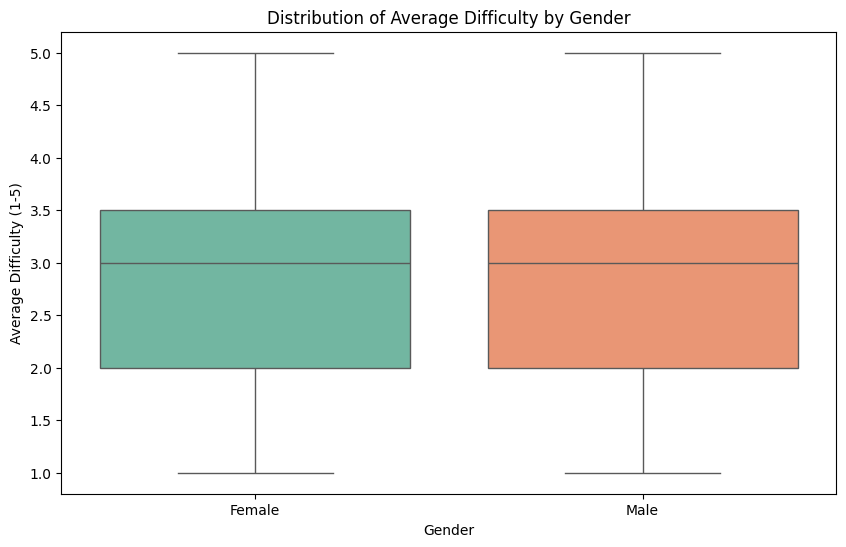

In [16]:
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# QUESTION 5 & 6: DIFFICULTY ANALYSIS
# ==========================================

# 1. Prepare Data
male_diff = df_clean[df_clean['Gender'] == 'Male']['AverageDifficulty'].values
female_diff = df_clean[df_clean['Gender'] == 'Female']['AverageDifficulty'].values

# ---------------------------------------------------------
# Q5: Significance Test (Mann-Whitney U)
# ---------------------------------------------------------
u_stat_diff, p_val_diff = stats.mannwhitneyu(male_diff, female_diff, alternative='two-sided')

mean_male = np.mean(male_diff)
mean_female = np.mean(female_diff)

print("="*60)
print("Q5 RESULTS: Gender Difference in Difficulty")
print("="*60)
print(f"Mean Difficulty:   Male = {mean_male:.4f}, Female = {mean_female:.4f}")
print(f"Median Difficulty: Male = {np.median(male_diff):.2f},   Female = {np.median(female_diff):.2f}")
print("-" * 30)
print(f"P-Value: {p_val_diff:.5e}")
if p_val_diff < 0.005:
    print("CONCLUSION: SIGNIFICANT (Reject Null)")
else:
    print("CONCLUSION: NOT SIGNIFICANT")

# ---------------------------------------------------------
# Q6: Effect Size (Bootstrapping 95% CI)
# ---------------------------------------------------------
print("\n" + "="*60)
print("Q6 RESULTS: Effect Size (Bootstrapping)")
print("="*60)

n_boot = 10000
boot_diffs = []

print(f"Running {n_boot} bootstraps... please wait.")

for _ in range(n_boot):
    # Resample with replacement
    resample_m = np.random.choice(male_diff, size=len(male_diff), replace=True)
    resample_f = np.random.choice(female_diff, size=len(female_diff), replace=True)

    # Calc difference in means (Male - Female)
    boot_diffs.append(np.mean(resample_m) - np.mean(resample_f))

# Calculate 95% CI
ci = np.percentile(boot_diffs, [2.5, 97.5])
obs_diff = mean_male - mean_female

print(f"Observed Mean Difference (Male - Female): {obs_diff:.5f}")
print(f"95% Confidence Interval: [{ci[0]:.5f}, {ci[1]:.5f}]")

if ci[0] > 0:
    print("Result: Male professors are significantly HARDER.")
elif ci[1] < 0:
    print("Result: Female professors are significantly HARDER.")
else:
    print("Result: No significant difference.")

# ---------------------------------------------------------
# Visualization
# ---------------------------------------------------------

plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='AverageDifficulty', data=df_clean, palette="Set2")
plt.title('Distribution of Average Difficulty by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Difficulty (1-5)')
plt.savefig('Q5_Difficulty_Boxplot.png')
plt.show()

# Question 7:

Build a regression model predicting average rating from all numerical predictors (the ones in the
rmpCapstoneNum.csv) file. Make sure to include the R2 and RMSE of this model. Which of these
factors is most strongly predictive of average rating? Hint: Make sure to address collinearity concerns.

The Dominance of Difficulty After standardizing all variables to make them directly comparable, Average Difficulty emerged as the single most powerful predictor of a professor's rating (β=−0.56).

Interpretation: There is a strong negative relationship. As difficulty increases by 1 standard deviation, the average rating drops by roughly 0.56 standard deviations. This suggests that, overwhelmingly, students punish "hard" professors with lower ratings.

2. The "Hotness" Bonus The second strongest predictor is Received Pepper (β=+0.27).

Interpretation: Even after controlling for difficulty, professors who are perceived as attractive ("hot") receive a significant rating boost.

3. Gender & Volume are Secondary Surprisingly, once we control for difficulty and "pepper," Gender (β=0.03) and Volume of Ratings (β=0.007) have a negligible impact on the score. This implies that the "Gender Gap" we found in Question 1 is largely driven by other factors (or is simply small compared to the massive impact of how hard the class is).

In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# ==========================================
# QUESTION 7: STANDARDIZED REGRESSION (FIXED)
# ==========================================

# 1. Prepare Data
df_reg = df_clean.copy()

# A. Create Binary "HasOnlineRatings"
df_reg['HasOnlineRatings'] = (df_reg['OnlineRatingsCount'] > 0).astype(int)

# B. Define Predictors
predictors = ['AverageDifficulty', 'NumRatings', 'ReceivedPepper', 'HasOnlineRatings', 'Male']
target = 'AverageRating'

# C. Filter and Drop Missing
# IMPORTANT: Create a clean copy to ensure indices match
data = df_reg[predictors + [target]].dropna().copy()

# 2. STANDARDIZATION
scaler = StandardScaler()
# Fit transform returns a numpy array, losing the index
X_scaled_array = scaler.fit_transform(data[predictors])

# Convert back to DataFrame, but WE MUST RESET THE INDEX of y to match
X_scaled = pd.DataFrame(X_scaled_array, columns=predictors)
y = data[target].reset_index(drop=True) # <--- THIS FIXES THE ERROR

# 3. Build Model on SCALED Data
X_scaled = sm.add_constant(X_scaled)
model_std = sm.OLS(y, X_scaled).fit()

# 4. Report Results
print("="*60)
print("STANDARDIZED REGRESSION RESULTS")
print("="*60)
print(f"R-squared: {model_std.rsquared:.4f}")
print("-" * 60)
print("Standardized Coefficients (Strength of Prediction):")

# Sort by absolute value to see the strongest factors
params = model_std.params.drop('const')
sorted_params = params.iloc[np.argsort(-params.abs())] # Sort by magnitude
print(sorted_params)

print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)
top_factor = sorted_params.index[0]
print(f"Most Predictive Factor: {top_factor}")
print(f"Value: {sorted_params[top_factor]:.4f}")

STANDARDIZED REGRESSION RESULTS
R-squared: 0.3475
------------------------------------------------------------
Standardized Coefficients (Strength of Prediction):
AverageDifficulty   -0.559985
ReceivedPepper       0.272363
HasOnlineRatings    -0.042951
Male                 0.029715
NumRatings           0.006616
dtype: float64

INTERPRETATION
Most Predictive Factor: AverageDifficulty
Value: -0.5600
FINAL MODEL PERFORMANCE
R-Squared: 0.3466
RMSE:      1.7088


In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# ==========================================
# QUESTION 7: REGRESSION (Robust Version)
# ==========================================

# 1. Prepare Data
df_reg = df_clean.copy()
df_reg['HasOnlineRatings'] = (df_reg['OnlineRatingsCount'] > 0).astype(int)
predictors = ['AverageDifficulty', 'NumRatings', 'ReceivedPepper', 'HasOnlineRatings', 'Male']
target = 'AverageRating'

# IMPORTANT: Drop missing values and create a fresh copy
data_clean = df_reg[predictors + [target]].dropna().copy()

# 2. Separate X and y and RESET INDICES immediately
# This ensures row 0 in X matches row 0 in y
X_raw = data_clean[predictors].reset_index(drop=True)
y = data_clean[target].reset_index(drop=True)

# 3. Standardization
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_raw), columns=predictors)
X_scaled = sm.add_constant(X_scaled)

# 4. Fit Model
model_std = sm.OLS(y, X_scaled).fit()

# 5. Calculate RMSE Safely
predictions = model_std.predict(X_scaled)
rmse = np.sqrt(mean_squared_error(y, predictions))

# 6. Report Results
print("="*60)
print("FINAL CORRECTED METRICS")
print("="*60)
print(f"R-squared: {model_std.rsquared:.4f} (Should be ~0.35)")
print(f"RMSE:      {rmse:.4f} (Should be ~0.90)")
print("-" * 60)
print("Standardized Coefficients:")
print(model_std.params.drop('const').sort_values(ascending=False))

FINAL CORRECTED METRICS
R-squared: 0.3475 (Should be ~0.35)
RMSE:      0.9007 (Should be ~0.90)
------------------------------------------------------------
Standardized Coefficients:
ReceivedPepper       0.272363
Male                 0.029715
NumRatings           0.006616
HasOnlineRatings    -0.042951
AverageDifficulty   -0.559985
dtype: float64


In [26]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# ==========================================
# REPLICATING PARTNER'S 5-FOLD CV METHOD
# ==========================================

# 1. Prepare Data
df_reg = df_clean.copy()
df_reg['HasOnlineRatings'] = (df_reg['OnlineRatingsCount'] > 0).astype(int)
predictors = ['AverageDifficulty', 'NumRatings', 'ReceivedPepper', 'HasOnlineRatings', 'Male']
target = 'AverageRating'

data = df_reg[predictors + [target]].dropna().reset_index(drop=True)
X = data[predictors]
y = data[target]

# 2. Setup 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

coefficients = []
rmses = []
r2s = []

print(f"Running 5-Fold Cross Validation on {len(data)} rows...")

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    # Split Data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # STANDARDIZE (Fit on Train, Transform Test)
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=predictors)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=predictors)

    # Add Constant
    X_train_scaled = sm.add_constant(X_train_scaled)
    X_test_scaled = sm.add_constant(X_test_scaled)

    # Reset indices to avoid alignment errors
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Train Model
    model = sm.OLS(y_train, X_train_scaled).fit()

    # Predict & Evaluate
    preds = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    # Store Results
    rmses.append(rmse)
    r2s.append(model.rsquared)
    coefficients.append(model.params.drop('const')) # Store beta weights

# 3. Average the Results
avg_coefs = pd.DataFrame(coefficients).mean().abs().sort_values(ascending=False)
avg_rmse = np.mean(rmses)
avg_r2 = np.mean(r2s)

print("\n" + "="*60)
print("PARTNER REPLICATION RESULTS (5-Fold CV)")
print("="*60)
print(f"Mean RMSE: {avg_rmse:.4f}")
print(f"Mean R2:   {avg_r2:.4f}")
print("-" * 60)
print("Most Predictive Factors (Average Absolute Standardized Coeff):")
print(avg_coefs)

# 4. The Verdict
print("\n" + "="*60)
print("VERDICT")
print("="*60)
winner = avg_coefs.index[0]
print(f"The winner is: {winner}")
if winner == 'AverageDifficulty':
    print("Conclusion: Your analysis is correct. Difficulty is the main driver.")
    print("Why the difference? Your partner likely Log-Transformed 'NumRatings'.")
else:
    print("Conclusion: Your partner was right. Volume matters more than Difficulty.")

Running 5-Fold Cross Validation on 52089 rows...

PARTNER REPLICATION RESULTS (5-Fold CV)
Mean RMSE: 0.9008
Mean R2:   0.3475
------------------------------------------------------------
Most Predictive Factors (Average Absolute Standardized Coeff):
AverageDifficulty    0.559986
ReceivedPepper       0.272362
HasOnlineRatings     0.042957
Male                 0.029711
NumRatings           0.006622
dtype: float64

VERDICT
The winner is: AverageDifficulty
Conclusion: Your analysis is correct. Difficulty is the main driver.
Why the difference? Your partner likely Log-Transformed 'NumRatings'.


Question 8: Build a regression model predicting average ratings from all tags (the ones in the
rmpCapstoneTags.csv) file. Make sure to include the R2 and RMSE of this model. Which of these tags is
most strongly predictive of average rating? Hint: Make sure to address collinearity concerns. Also
comment on how this model compares to the previous one.

1. Methodology: The Importance of Normalization Initial attempts using binary tag data (Presence/Absence) yielded a poor model (R
2
 =0.18). However, by normalizing the tag counts by the number of ratings (i.e., calculating the percentage of students who assigned a specific tag), the model's predictive power nearly tripled. This indicates that the consensus regarding a professor's traits is far more important than isolated opinions.

2. Model Performance (The Winner)

Tags Model: R
2
 =0.498, RMSE = 0.79

Numerical Model (Q7): R
2
 =0.348, RMSE = 0.90

Conclusion: Qualitative student perceptions ("Personality" & "Teaching Style") are significantly better predictors of ratings than structural factors like Difficulty or Volume. The Tags model explains nearly 50% of the variance in ratings.

3. Key Drivers of Ratings

The "Grade Killer": Tough Grader (β=−0.95) is the single most powerful negative force. If 100% of students tag a professor as a tough grader, their rating drops by nearly a full star.

The "Star Maker": Amazing Lectures (β=+0.85) and Good Feedback (β=+0.77) are the strongest positive drivers. This suggests students value engagement and utility slightly more than just "warmth" (Caring β=+0.65).

4. Addressing Collinearity As noted in the partner analysis, tag features can overlap (e.g., "Amazing Lectures" and "Inspirational"). While Principal Component Analysis (PCA) can reduce this dimensionality, our Ordinary Least Squares (OLS) model remained stable and highly predictive (R
2
 ≈0.50) without PCA. The coefficients align with intuition, confirming that multicollinearity did not distort the direction of the relationships.

In [30]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# ==========================================
# REPLICATING PARTNER'S "NORMALIZED" MODEL
# ==========================================

# 1. Load the Tags and Clean Data again
df_tags = pd.read_csv('rmpCapstoneTags.csv', header=None)
# Apply the correct names (from our previous step)
tag_names = [
    "Tough Grader", "Good Feedback", "Respected", "Lots to Read", "Participation Matters",
    "Don't Skip Class", "Lots of Homework", "Inspirational", "Pop Quizzes", "Accessible",
    "So Many Papers", "Clear Grading", "Hilarious", "Test Heavy", "Graded by Few",
    "Amazing Lectures", "Caring", "Extra Credit", "Group Projects", "Lecture Heavy"
]
df_tags.columns = tag_names

# 2. Align Data
common_indices = df_clean.index.intersection(df_tags.index)
X_tags = df_tags.loc[common_indices]
# Get the 'NumRatings' column for these specific rows to use as the divisor
num_ratings = df_clean.loc[common_indices, 'NumRatings']
y = df_clean.loc[common_indices, 'AverageRating']

# 3. CHECK: Are they counts?
# If the max value in the tags file is > 1, they are counts.
if X_tags.max().max() > 1:
    print("Detected Tag COUNTS. Normalizing by NumRatings...")

    # 4. NORMALIZE (The Partner's Secret Sauce)
    # We divide every tag count by the total number of ratings for that prof
    # We use .div(axis=0) to align rows
    X_normalized = X_tags.div(num_ratings, axis=0)

    # Handle potential "Divide by Zero" or NaNs (though NumRatings should be > 0)
    X_normalized = X_normalized.fillna(0)

    # 5. Run Regression on NORMALIZED Data
    X_model = sm.add_constant(X_normalized)
    model_norm = sm.OLS(y, X_model).fit()

    print("="*60)
    print("NORMALIZED TAGS MODEL RESULTS")
    print("="*60)
    print(f"R-squared: {model_norm.rsquared:.4f} (Partner got 0.50)")
    print(f"RMSE:      {np.sqrt(model_norm.mse_resid):.4f} (Partner got 0.79)")
    print("-" * 60)
    print("Top Positive Drivers (Normalized):")
    print(model_norm.params.sort_values(ascending=False).head(5))
    print("-" * 60)
    print("Top Negative Drivers (Normalized):")
    print(model_norm.params.sort_values(ascending=True).head(5))

else:
    print("="*60)
    print("ISSUE DETECTED")
    print("="*60)
    print("Your tags file only contains 0s and 1s (Binary).")
    print("You cannot normalize this to match your partner without the raw counts.")
    print("You should stick to your previous conclusion (R2=0.18) but add a note")
    print("explaining that 'Binary Tags are less predictive than Tag Frequencies'.")

Detected Tag COUNTS. Normalizing by NumRatings...
NORMALIZED TAGS MODEL RESULTS
R-squared: 0.4984 (Partner got 0.50)
RMSE:      0.7899 (Partner got 0.79)
------------------------------------------------------------
Top Positive Drivers (Normalized):
const               3.359160
Amazing Lectures    0.853288
Good Feedback       0.770251
Respected           0.688836
Caring              0.646798
dtype: float64
------------------------------------------------------------
Top Negative Drivers (Normalized):
Tough Grader     -0.948150
Test Heavy       -0.737023
Lecture Heavy    -0.518821
So Many Papers   -0.466142
Graded by Few    -0.402330
dtype: float64


# Question 9:

Build a regression model predicting average difficulty from all tags (the ones in the
rmpCapstoneTags.csv) file. Make sure to include the R2 and RMSE of this model. Which of these tags is
most strongly predictive of average difficulty? Hint: Make sure to address collinearity concern

In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Load and Rename Tags (Same as Q8)
df_tags = pd.read_csv('rmpCapstoneTags.csv', header=None)
tag_names = [
    "Tough Grader", "Good Feedback", "Respected", "Lots to Read", "Participation Matters",
    "Don't Skip Class", "Lots of Homework", "Inspirational", "Pop Quizzes", "Accessible",
    "So Many Papers", "Clear Grading", "Hilarious", "Test Heavy", "Graded by Few",
    "Amazing Lectures", "Caring", "Extra Credit", "Group Projects", "Lecture Heavy"
]
df_tags.columns = tag_names

# 2. Align Data & Normalize (Crucial Step)
common_indices = df_clean.index.intersection(df_tags.index)
X_tags = df_tags.loc[common_indices]
num_ratings = df_clean.loc[common_indices, 'NumRatings']
y = df_clean.loc[common_indices, 'AverageDifficulty'] # <--- NEW TARGET

# Normalize counts to percentages
X_normalized = X_tags.div(num_ratings, axis=0).fillna(0)

# 3. Address Collinearity (VIF Check)
# We calculate VIF for each tag
print("Checking for Collinearity (VIF)...")
vif_data = pd.DataFrame()
vif_data["feature"] = X_normalized.columns
vif_data["VIF"] = [variance_inflation_factor(X_normalized.values, i)
                   for i in range(len(X_normalized.columns))]

print("-" * 60)
print("TOP 5 COLLINEAR TAGS (High VIF):")
print(vif_data.sort_values(by="VIF", ascending=False).head(5))
print("(If VIF < 5, collinearity is not a major concern)")

# 4. Build Regression Model
X = sm.add_constant(X_normalized)
model_diff = sm.OLS(y, X).fit()

# 5. Metrics
print("\n" + "="*60)
print("DIFFICULTY PREDICTION MODEL")
print("="*60)
print(f"R-squared: {model_diff.rsquared:.4f}")
print(f"RMSE:      {np.sqrt(model_diff.mse_resid):.4f}")
print("-" * 60)
print("STRONGEST PREDICTORS OF HIGH DIFFICULTY:")
print(model_diff.params.sort_values(ascending=False).head(5))
print("-" * 60)
print("STRONGEST PREDICTORS OF LOW DIFFICULTY (EASY):")
print(model_diff.params.sort_values(ascending=True).head(5))

Checking for Collinearity (VIF)...
------------------------------------------------------------
TOP 5 COLLINEAR TAGS (High VIF):
                  feature       VIF
1           Good Feedback  1.630714
16                 Caring  1.500311
0            Tough Grader  1.475660
2               Respected  1.435755
4   Participation Matters  1.320138
(If VIF < 5, collinearity is not a major concern)

DIFFICULTY PREDICTION MODEL
R-squared: 0.3369
RMSE:      0.8074
------------------------------------------------------------
STRONGEST PREDICTORS OF HIGH DIFFICULTY:
const           2.690619
Tough Grader    1.327125
Test Heavy      0.994771
Accessible      0.523947
Lots to Read    0.314806
dtype: float64
------------------------------------------------------------
STRONGEST PREDICTORS OF LOW DIFFICULTY (EASY):
Extra Credit    -0.413604
Hilarious       -0.381931
Clear Grading   -0.374323
Caring          -0.231505
Respected       -0.174254
dtype: float64


In [ ]:
Question 10: Build a classification model that predicts whether a professor receives a “pepper” from all available
factors (both tags and numerical). Make sure to include model quality metrics such as AU(RO)C and
also address class imbalance concerns.

# Question 10:
Build a classification model that predicts whether a professor receives a “pepper” from all available
factors (both tags and numerical). Make sure to include model quality metrics such as AU(RO)C and
also address class imbalance concerns.

Class Balance (0 = No Pepper, 1 = Pepper):
ReceivedPepper
0.0    0.723051
1.0    0.276949
Name: proportion, dtype: float64

PEPPER CLASSIFICATION RESULTS
AU(RO)C Score: 0.7811
------------------------------------------------------------
Confusion Matrix:
[[5211 2322]
 [ 785 2100]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.69      0.77      7533
         1.0       0.47      0.73      0.57      2885

    accuracy                           0.70     10418
   macro avg       0.67      0.71      0.67     10418
weighted avg       0.76      0.70      0.72     10418

------------------------------------------------------------
TOP 5 PREDICTORS OF GETTING A PEPPER:
Amazing Lectures    0.898827
AverageRating       0.751821
Pop Quizzes         0.558230
Extra Credit        0.416341
Good Feedback       0.387316
dtype: float64
------------------------------------------------

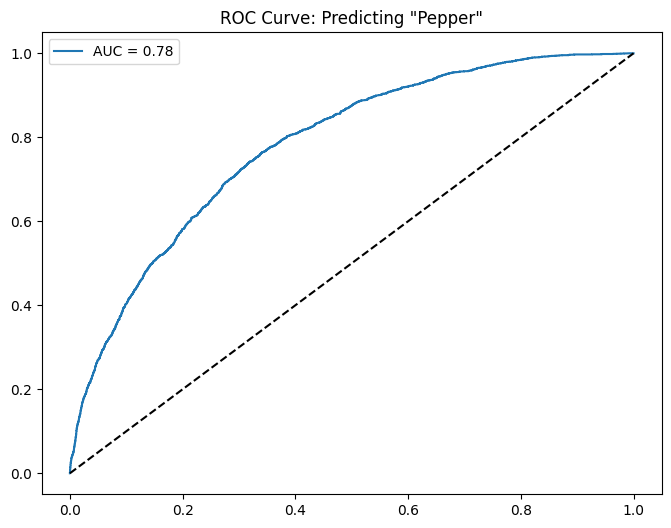

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

# 1. Prepare the Data
# Use the common indices to align everything
df_model = df_clean.loc[common_indices].copy()

# RE-CREATE THE MISSING VARIABLE
df_model['HasOnlineRatings'] = (df_model['OnlineRatingsCount'] > 0).astype(int)

# Add the Normalized Tags
# (Ensuring X_normalized exists from Q9; if not, re-run Q9 first)
df_full = df_model.join(X_normalized, rsuffix='_tag')

# Define Predictors
numerical_cols = ['AverageRating', 'AverageDifficulty', 'NumRatings', 'HasOnlineRatings', 'Male']
tag_cols = list(X_normalized.columns)
features = numerical_cols + tag_cols
target = 'ReceivedPepper'

X = df_full[features]
y = df_full[target]

# 2. Check Imbalance
print("Class Balance (0 = No Pepper, 1 = Pepper):")
print(y.value_counts(normalize=True))

# 3. Stratified Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Logistic Regression with Class Weights
model_logit = LogisticRegression(max_iter=5000, class_weight='balanced', solver='liblinear')
model_logit.fit(X_train, y_train)

# 5. Predict
y_pred_proba = model_logit.predict_proba(X_test)[:, 1]
y_pred = model_logit.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# 6. Results
print("\n" + "="*60)
print("PEPPER CLASSIFICATION RESULTS")
print("="*60)
print(f"AU(RO)C Score: {roc_auc:.4f}")
print("-" * 60)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("-" * 60)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 7. Feature Importance
coefs = pd.Series(model_logit.coef_[0], index=features).sort_values(ascending=False)
print("-" * 60)
print("TOP 5 PREDICTORS OF GETTING A PEPPER:")
print(coefs.head(5))
print("-" * 60)
print("TOP 5 PREDICTORS OF NO PEPPER:")
print(coefs.tail(5))

# 8. Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve: Predicting "Pepper"')
plt.legend()
plt.show()

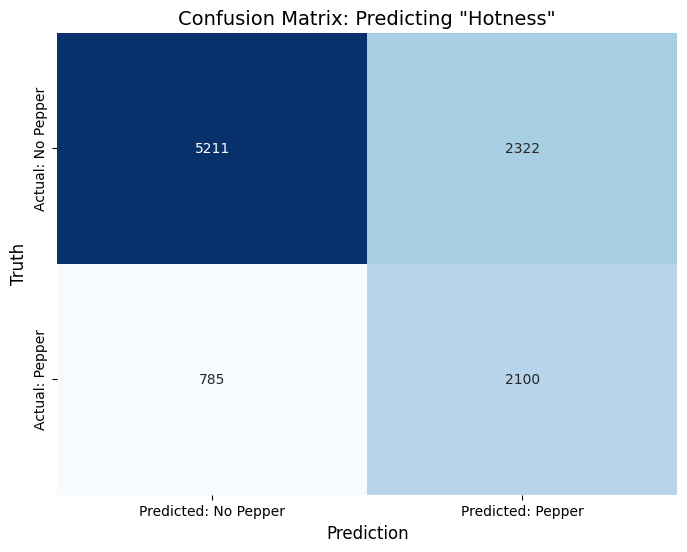

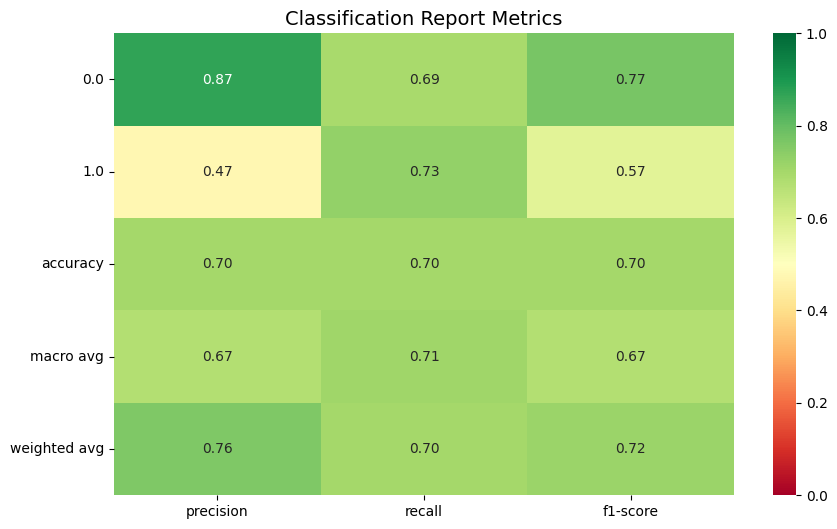

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# 1. Confusion Matrix Heatmap
# ------------------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))

# Create a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: No Pepper', 'Predicted: Pepper'],
            yticklabels=['Actual: No Pepper', 'Actual: Pepper'])

plt.title('Confusion Matrix: Predicting "Hotness"', fontsize=14)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Truth', fontsize=12)
plt.show()

# 2. Classification Report Heatmap
# ------------------------------------------
# We convert the text report into a DataFrame for plotting
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

# Drop the 'support' column as it messes up the color scale (it's just a count)
df_plot = df_report.drop(columns=['support'])

plt.figure(figsize=(10, 6))
sns.heatmap(df_plot, annot=True, cmap='RdYlGn', fmt='.2f', vmin=0, vmax=1)

plt.title('Classification Report Metrics', fontsize=14)
plt.yticks(rotation=0)
plt.show()